# Transcriptome-Wide Association Study (TWAS) using High-dimensional Regression Methods

This notebook demonstrates how to perform Transcriptome-Wide Association Studies (TWAS) using weights derived from various high-dimensional regression methods including SuSiE, mvSuSiE and mr.mash. TWAS integrates eQTL data with GWAS summary statistics to identify gene-trait associations. The key idea is that if genetic variants affect both gene expression (eQTL effects) and trait (GWAS effects), we can aggregate these effects using learned weights from expression data to test for gene-trait associations.

For details on high-dimensional regression methods used to obtain weights, please refer to:
- `finemapping.ipynb`
- `multivariate_finemapping.ipynb`
- `mr_mash.ipynb`

Although we simulate expression data in 5 tissues to demonstrate multivariate methods capabilities, for simplicity in this TWAS exercise we will focus on using weights from the first tissue context to perform TWAS test.

In [1]:
library(susieR)
library(mvsusieR)
library(mr.mash.alpha)
set.seed(1)

Loading required package: mashr

Loading required package: ashr



## TWAS Test Definition

The goal of this exercise is to demonstrate how to compute TWAS (Transcriptome-Wide Association Study) test statistics using weights learned from various high-dimensional regression methods. Before we proceed with model fitting, we first introduce the TWAS test statistic.

The TWAS test combines eQTL weights with GWAS z-scores to compute a gene-level association statistic. The test statistic is computed as:

$$Z_{\text{TWAS}} = \frac{w^T z}{\sqrt{w^T R w}}$$

where $w$ is the vector of weights, $z$ is the vector of GWAS z-scores, and $R$ is the LD matrix. This is implemented in the following function:

In [2]:
twas_z <- function(weights, z, R = NULL, X = NULL) {
  if (length(weights) != length(z)) {
    stop("Weights and z-scores must have the same length.")
  }
  if (is.null(R)) R <- cor(X)
  stat <- t(weights) %*% z
  denom <- t(weights) %*% R %*% weights
  zscore <- stat / sqrt(denom)
  pval <- pchisq(zscore * zscore, 1, lower.tail = FALSE)
  return(list(z = zscore, pval = pval))
}

## Simulate molecular trait data

We'll use the same simulation setup as in the mr.mash tutorial, simulating expression of a gene across 5 tissues:

In [3]:
dat <- simulate_mr_mash_data(n = 300, p = 500, p_causal = 3, r = 5, pve = 0.25, V_cor = 0.25)
# Split into training and test sets
ntest <- 50
Ytrain <- dat$Y[-(1:ntest),]
Xtrain <- dat$X[-(1:ntest),]
Ytest <- dat$Y[1:ntest,]
Xtest <- dat$X[1:ntest,]

## Obtain weights from different methods

First, let's fit univariate SuSiE using the first tissue:

In [4]:
fit_susie <- susie(Xtrain, Ytrain[,1], L=10)

Next, we'll fit mr.mash, which will also provide residual variance estimates:

In [5]:
# Fit mr.mash
S0 <- compute_canonical_covs(r=5, singletons=TRUE, hetgrid=seq(0,1,0.25))
univ_sumstats <- compute_univariate_sumstats(Xtrain, Ytrain, standardize=TRUE)
scaling_grid <- autoselect.mixsd(univ_sumstats, mult=sqrt(2))^2
S0 <- expand_covs(S0, scaling_grid)
fit_mrmash <- mr.mash(X=Xtrain, Y=Ytrain, S0=S0)

Processing the inputs... Done!
Fitting the optimization algorithm using 12 RcppParallel threads... 
 iter    mu1_max.diff     ELBO_diff               ELBO
   1       2.38e-01            Inf      -1.59878145270982258808e+03
   2       6.49e-02       1.90e+02      -1.40903793223060233686e+03
   3       1.99e-02       3.50e+01      -1.37401598219291190617e+03
   4       1.61e-02       1.25e+01      -1.36152035583163160481e+03
   5       1.23e-02       6.01e+00      -1.35551340874110928780e+03
   6       9.45e-03       3.50e+00      -1.35201135740664676632e+03
   7       7.41e-03       2.29e+00      -1.34972612273548179473e+03
   8       5.93e-03       1.60e+00      -1.34812392786327291105e+03
   9       4.85e-03       1.18e+00      -1.34694206152203992133e+03
  10       4.02e-03       9.06e-01      -1.34603592745314881540e+03
  11       3.39e-03       7.16e-01      -1.34531951656050773636e+03
  12       2.88e-03       5.81e-01      -1.34473864484809655551e+03
  13       2.47e-03       4.8

Finally, we'll fit mvSuSiE using uniform mixture weights and canonical covariance matrices `S0`, removing the first component in `S0` which is the "null" effect. Note that for the residual variance, we can either use the estimate from mr.mash fit (as shown here) or directly use the covariance of Y. For prior specification, more sophisticated approaches exist, particularly the multivariate adaptive shrinkage (mash) model (Urbut et al. 2019, Nature Genetics) which can learn complex patterns of effect sharing across tissues.

In [6]:
# Get uniform weights
n_comp <- length(S0[-1])
w0 <- rep(1/n_comp, n_comp)

# Create prior
prior <- create_mixture_prior(list(matrices = S0,
                                  weights = w0),
                             null_weight = 0)

# Fit mvSuSiE using mr.mash residual variance
fit_mvsusie <- mvsusie(Xtrain, Ytrain, standardize = TRUE,
                       prior_variance = prior,
                       residual_variance = fit_mrmash$V,
                       estimate_prior_variance = TRUE)

Initializing data object...

Dimension of X matrix: 250 500

Dimension of Y matrix: 250 5

Initializing prior object ...

Number of components in the mixture prior: 161

Running IBSS algorithm...

Iteration 1 delta = Inf

Iteration 2 delta = 0.354293163260763

Iteration 3 delta = 0.170515964272226

Iteration 4 delta = 0.144597648487434

Iteration 5 delta = 0.129188886864767

Iteration 6 delta = 0.117506011440355

Iteration 7 delta = 0.108246785269557

Iteration 8 delta = 0.10062553753005

Iteration 9 delta = 0.0941665951988853

Iteration 10 delta = 0.0885703448248023

Iteration 11 delta = 0.268079373159253

Iteration 12 delta = 1.52372943924934

Iteration 13 delta = 0.0122211395946579

Iteration 14 delta = 0.0109349285389726

Iteration 15 delta = 0.00984430061612329

Iteration 16 delta = 0.00891164230961294

Iteration 17 delta = 0.00810779021435337

Iteration 18 delta = 0.00740973923893762

Iteration 19 delta = 0.00679926625048211

Iteration 20 delta = 0.00626194910455524

Iteration 21

## Extract and compare weights

Let's visualize the weights (coefficients) from different methods for the first tissue:

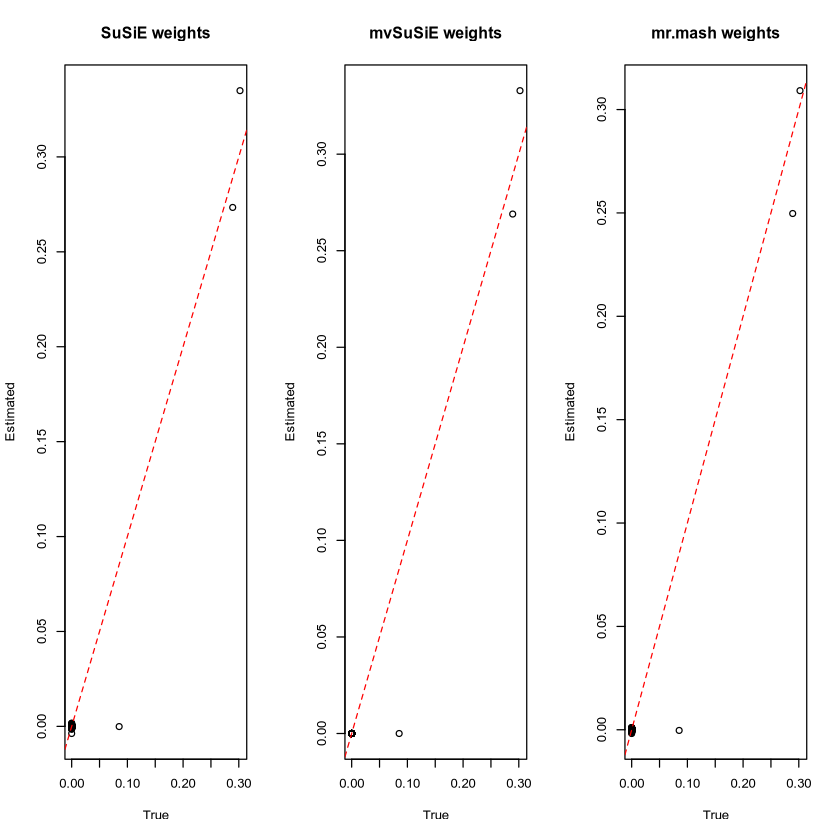

In [7]:
par(mfrow=c(1,3))
plot(dat$B[,1], coef(fit_susie)[-1], main="SuSiE weights", 
     xlab="True", ylab="Estimated")
abline(0,1,col='red',lty=2)

plot(dat$B[,1], coef(fit_mvsusie)[,1][-1], 
     main="mvSuSiE weights", xlab="True", ylab="Estimated")
abline(0,1,col='red',lty=2)

plot(dat$B[,1], fit_mrmash$mu1[,1], 
     main="mr.mash weights", xlab="True", ylab="Estimated")
abline(0,1,col='red',lty=2)

It seems all the 3 methods perform similarly, correctly captured two out of the 3 simulated effects.

## Simulate GWAS z-scores

We'll simulate GWAS z-scores taking into account the LD structure (R). The z-scores are generated under the assumption that variants affecting gene expression in the first tissue also affect the trait with correlated effect sizes:

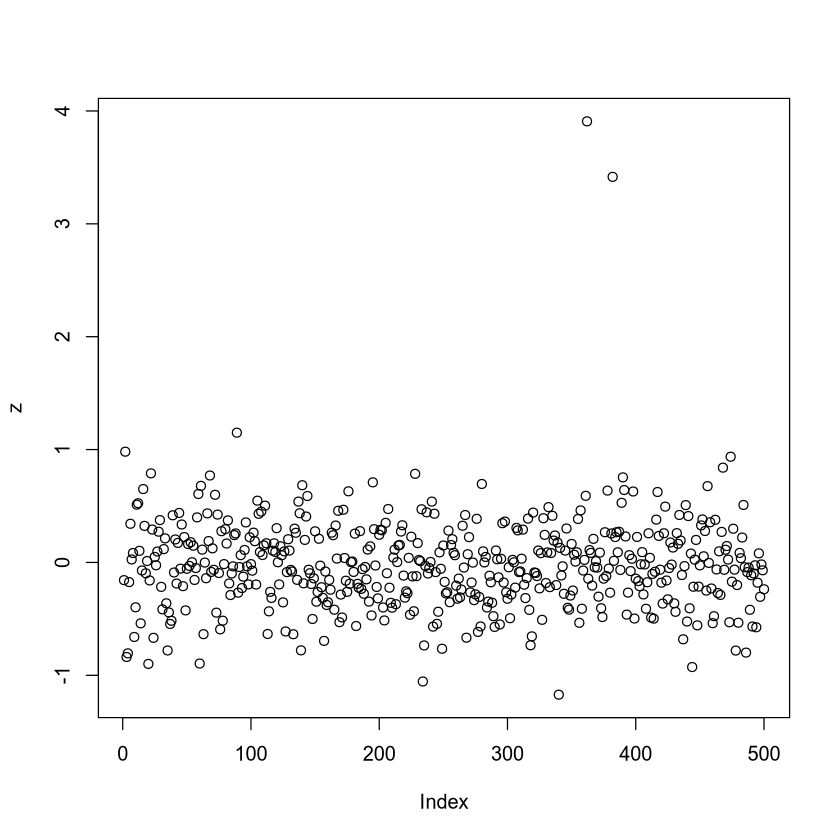

In [23]:
# Compute LD matrix
R <- cor(Xtrain)
# Simulate z-scores
set.seed(1)
true_effects <- (dat$B[,1] != 0) * rnorm(length(dat$B[,1]), sd=3)
z <- R %*% true_effects
plot(z)

## Perform TWAS

Let's perform TWAS using weights from each method focusing on the first tissue:

In [24]:
# Compute TWAS results using different weights
twas_susie <- twas_z(coef(fit_susie)[-1], z, R)
twas_mvsusie <- twas_z(coef(fit_mvsusie)[,1][-1], z, R)
twas_mrmash <- twas_z(fit_mrmash$mu1[,1], z, R)

# Display results
results <- data.frame(
  Method = c("SuSiE", "mvSuSiE", "mr.mash"),
  Z_score = c(twas_susie$z, twas_mvsusie$z, twas_mrmash$z),
  P_value = c(twas_susie$pval, twas_mvsusie$pval, twas_mrmash$pval)
)
print(results)

   Method  Z_score      P_value
1   SuSiE 5.106636 3.279447e-07
2 mvSuSiE 5.104448 3.317613e-07
3 mr.mash 5.099474 3.405982e-07


## Computing TWAS weights using additional regression methods

The `pecotmr` package (https://github.com/cumc/pecotmr/) provides a unified interface for computing TWAS weights using various high-dimensional regression methods. Here's how to use them:


In [12]:
library(pecotmr)

In [14]:
# Create a character vector of weight methods to use
# Each method corresponds to a `*_weights()` function in pecotmr
methods <- c("susie_weights", "enet_weights", "lasso_weights", "mrash_weights", 
            "bayes_n_weights", "bayes_l_weights", "bayes_a_weights", 
            "bayes_c_weights", "bayes_r_weights")

# Compute weights using all methods
# Only using the first tissue for demonstration
weights <- twas_weights(Xtrain, Ytrain[,1], 
                       weight_methods = methods)

Total time elapsed for susie_wrapper: 0.311000000000035



Mr.ASH terminated at iteration 1000.


Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld

Type of analysis performed: st-blr-individual-level-dense-ld



Vasualize weights from different methods against true effects,

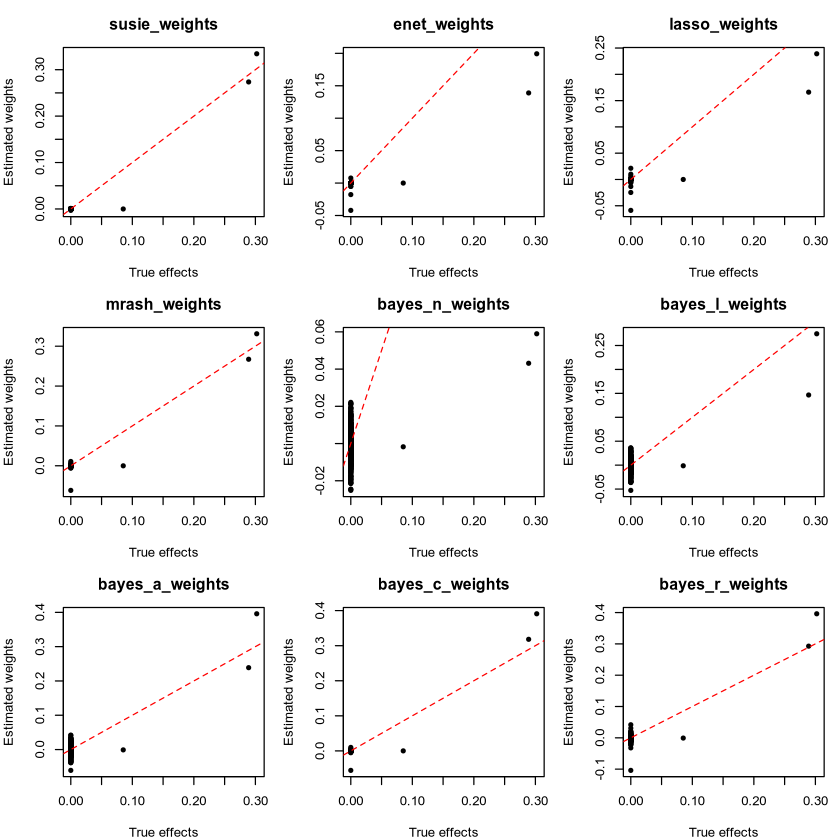

In [15]:
par(mfrow = c(3,3), mar = c(4,4,3,1))
for (method in methods) {
  plot(dat$B[,1], weights[[method]], 
       main = method,
       xlab = "True effects", 
       ylab = "Estimated weights",
       pch = 20)
  abline(0, 1, col = 'red', lty = 2)
}

Perform TWAS using weights from each method,

In [16]:
twas_results <- data.frame(
  Method = methods,
  Z_score = NA,
  P_value = NA
)

for (i in seq_along(methods)) {
  method <- methods[i]
  res <- twas_z(weights[[method]], z, R)
  twas_results$Z_score[i] <- res$z
  twas_results$P_value[i] <- res$pval
}

print(twas_results)

           Method  Z_score      P_value
1   susie_weights 5.109448 3.231006e-07
2    enet_weights 4.964651 6.882460e-07
3   lasso_weights 4.917999 8.743333e-07
4   mrash_weights 5.048043 4.463589e-07
5 bayes_n_weights 2.812804 4.911157e-03
6 bayes_l_weights 3.414550 6.388752e-04
7 bayes_a_weights 3.713308 2.045679e-04
8 bayes_c_weights 5.078750 3.799269e-07
9 bayes_r_weights 4.684785 2.802536e-06
